In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

from nltk.corpus import stopwords
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sentence_transformers import SentenceTransformer

import torch
from scipy.sparse import hstack

In [92]:
data = pd.read_csv('data/European Restaurant Reviews.csv')
data

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the carbonara was not good. She was rude. It was a very bad experience. The worst in Rome in many years.
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20 minutes they brought me another steak that was completely rare, I left all the steak , and they asked me about it but charged me the fool price."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, albeit but somewhat slow service. The offerings are pleasingly presented but most everything has no taste. It was as though ingredients were just assembled without seasoning: a lovely restaurant, except for the food."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,"Sadly I used the high TripAdvisor rating too literally. We have been fortunate to eat at a number of fine restaurants so know that amazing buzz from a mouthful of fine freshly cooked food from a great chef.\nNever before have we eaten a tasting menu and never will we again.\nAd Hoc has a great ambience with attentive friendly service and all the paired wines were exceptional.\nMaybe we hit a night when the chef was off but every single course of food was certainly not freshly cooked and , as we passed the kitchen on the way to the bathroom, noticed plates of precooked food ready to go on the tasting menu plates. If it had been the odd dish that disappointed, we would have accepted that it might have just been our palates not liking it. As it was every plate of food was not hot, bland, lacking any spark and had probably been sitting around for a while.l\nAll the serving staff were great as was the wine but I failed to finish any plate offered. \nThe tasting menu looked good value but a simple bowl of hot freshly cooked pasta would have done better justice to the wine.\nWhen asked ,I admitted , with that great English understatement, that I had been disappointed. I found 17 euros had been deducted from the 190 euro bill so it was nice that they noticed.\nProbably best to avoid the tasting menus and enjoy their great wine selection with some pasta and maybe cheese course.\n\nI feel responsible that I made a poor choice not realizing that this is a place geared for tourists. \nAn expensive mistake."
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,"From the start this meal was bad- especially given the price. We visited for my husbands birthday after being recommended by our local hotel. The lady in charge appeared at our table as we arrived to basically up-sell the truffle menu. Plonked some truffles on the table and then with no explanation of how they would enhance the dishes gave us a rehearsed speech which she proceeded to repeat word for word at every single table. If the food had been good we could have forgiven this but it wasn’t. The best parts were the bland bits as at least they were inoffensive - nothing was seasoned and sauces were completely tasteless with strange and weird combinations. But the worst part of the meal was my husbands inedible medallions of ‘lamb’ dish. This was made up of a tiny amount of lamb gristle and fat wrapped around some mushy stuff we couldn’t identify. Fillet of beef was sort of well cooked (frankly hard to get wrong) but served with exactly the same sauce as the lamb, some reconstituted mash in strange tube shapes and tasteless, watery spinach. We asked for wine recommendations. The wines were ok but we weren’t told what they were, they weren’t explained to us (I had to ask what mine was and was told it was ‘local’) and we weren’t offered any to try. With so much choice nearby a

### Problem 7. Deep features (embeddings) (1 point)
Use the same model to perform feature extraction on the review contents (or contents + titles) instead of direct predictions. You should already be familiar how to do that from your work on images.

Use the cosine similarity between texts to try to cluster them. Are there "similar" reviews (you'll need to find a way to measure similarity) across different restaurants? Are customers generally in agreement for the same restaurant?

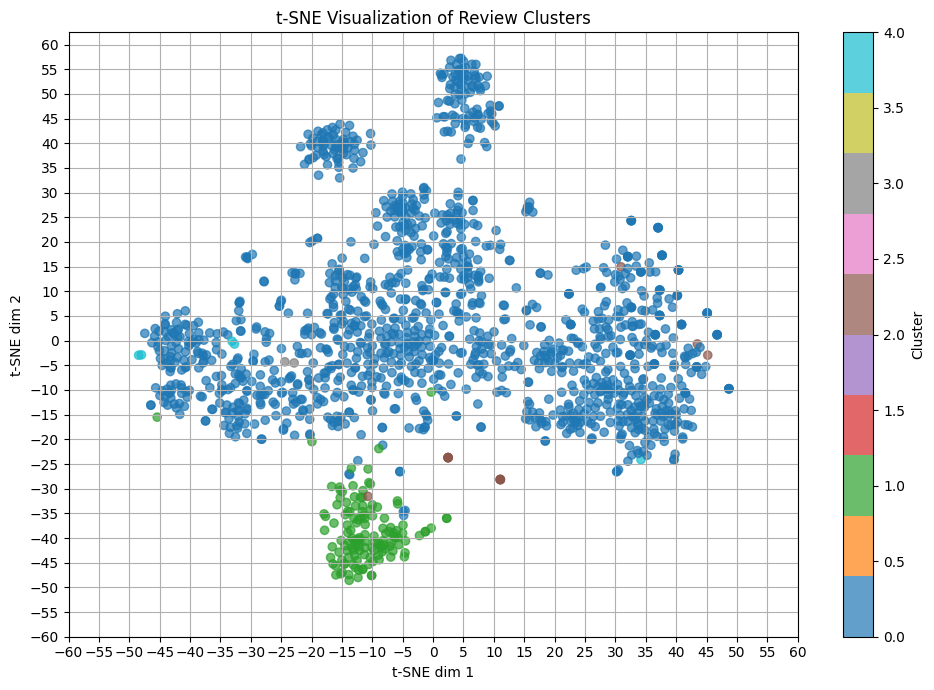

In [93]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
model = SentenceTransformer('all-MiniLM-L6-v2')

titles = data['Review Title'].fillna("").tolist()
reviews = data['Review'].fillna("").tolist()
combined_text = [f"Title: {t} | Review: {r}" for t, r in zip(titles, reviews)]

cls_embeddings = model.encode(combined_text, convert_to_numpy=True)

#Here we determine whether one vector is similar to another so that it can be added to a cluster in the future
similarity_matrix = cosine_similarity(cls_embeddings)

clustering = AgglomerativeClustering(n_clusters=5, metric='cosine', linkage='average')
cluster_labels = clustering.fit_predict(cls_embeddings)
data['Cluster'] = cluster_labels


tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embeddings = tsne.fit_transform(cls_embeddings)
data['x'] = tsne_embeddings[:, 0]
data['y'] = tsne_embeddings[:, 1]


plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    data['x'], data['y'],
    c=data['Cluster'],
    cmap='tab10',
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.title("t-SNE Visualization of Review Clusters")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True)

plt.xticks(range(-60, 61, 5))
plt.yticks(range(-60, 61, 5))

plt.tight_layout()
plt.show()

In [94]:
def find_review_on_scatterplot(x_target, y_target, tolerance):

    row = data[
        (data['x'].between(x_target - tolerance, x_target + tolerance)) &
        (data['y'].between(y_target - tolerance, y_target + tolerance))
    ]
    
    plt.figure(figsize=(10, 7))
    
    scatter = plt.scatter(
        data['x'], data['y'],
        c=data['Cluster'],
        cmap='tab10',
        alpha=0.7
    )
    
    plt.scatter(
        row['x'], row['y'],
        color='red',
        s=80,
        edgecolors='black',
        label='Selected point'
    )
    
    plt.colorbar(scatter, label='Cluster')
    plt.title("t-SNE Visualization of Review Clusters")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.grid(True)
    
    plt.xticks(range(-60, 61, 5))
    plt.yticks(range(-60, 61, 5))
    
    plt.legend()
    plt.tight_layout()
    plt.show()

In [95]:
data

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review,Cluster,x,y
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the carbonara was not good. She was rude. It was a very bad experience. The worst in Rome in many years.,2,45.196846,-2.942207
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20 minutes they brought me another steak that was completely rare, I left all the steak , and they asked me about it but charged me the fool price.",0,24.547806,6.376055
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, albeit but somewhat slow service. The offerings are pleasingly presented but most everything has no taste. It was as though ingredients were just assembled without seasoning: a lovely restaurant, except for the food.",0,5.452494,4.809688
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,"Sadly I used the high TripAdvisor rating too literally. We have been fortunate to eat at a number of fine restaurants so know that amazing buzz from a mouthful of fine freshly cooked food from a great chef.\nNever before have we eaten a tasting menu and never will we again.\nAd Hoc has a great ambience with attentive friendly service and all the paired wines were exceptional.\nMaybe we hit a night when the chef was off but every single course of food was certainly not freshly cooked and , as we passed the kitchen on the way to the bathroom, noticed plates of precooked food ready to go on the tasting menu plates. If it had been the odd dish that disappointed, we would have accepted that it might have just been our palates not liking it. As it was every plate of food was not hot, bland, lacking any spark and had probably been sitting around for a while.l\nAll the serving staff were great as was the wine but I failed to finish any plate offered. \nThe tasting menu looked good value but a simple bowl of hot freshly cooked pasta would have done better justice to the wine.\nWhen asked ,I admitted , with that great English understatement, that I had been disappointed. I found 17 euros had been deducted from the 190 euro bill so it was nice that they noticed.\nProbably best to avoid the tasting menus and enjoy their great wine selection with some pasta and maybe cheese course.\n\nI feel responsible that I made a poor choice not realizing that this is a place geared for tourists. \nAn expensive mistake.",0,30.669762,4.839140
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,"From the start this meal was bad- especially given the price. We visited for my husbands birthday after being recommended by our local hotel. The lady in charge appeared at our table as we arrived to basically up-sell the truffle menu. Plonked some truffles on the table and then with no explanation of how they would enhance the dishes gave us a rehearsed speech which she proceeded to repeat word for word at every single table. If the food had been good we could have forgiven this but it wasn’t. The best parts were the bland bits as at least they were inoffensive - nothing was seasoned and sauces were completely tasteless with strange and weird combinations. But the worst part of the meal was my husbands inedible medallions of ‘lamb’ dish. This was made up of a tiny amount of lamb gristle and fat wrapped around some mushy stuff we couldn’t identify. Fillet of beef was sort of well cooked (frankly hard to get wrong) but served with exactly the same sauce as the lamb, some reconstituted mash in strange tube shapes and tasteless, watery spinach. We asked for wine recommendations. The wines were ok but we weren’t told what they were, they weren’t explained to us (I had to ask what mine 

In [114]:
x_target = 5 
y_target = 50
tolerance = 5

In [115]:
row = data[
        (data['x'].between(x_target - tolerance, x_target + tolerance)) &
        (data['y'].between(y_target - tolerance, y_target + tolerance))
    ]
row

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review,Cluster,x,y
1046,Russia,Pelmenya,Negative,CHEAP BUT MEDIOCRE,Jan 2019 •,"Good location next to Fabergé museum which makes it very busy and crowded. Expect to wait for a table!\nRestaurant is pleasant and waitresses delightful.\nHowever, this restaurant which specializes in dumplings, from Italian raviolis to gioza, to Russian dumplings, etc, is quite low in quality! And the dumplings are mediocre, even though quite cheap:",0,1.204076,54.181580
1048,Russia,Pelmenya,Negative,Disappointing!,May 2018 •,"I don't understand why people rave about this place. Went here with two friends based on the tripadvisor rating, and all three of us were thoroughly disappointed! We had pelmeni and varenniki with cherries. The dough in both was way too thick and doughy, and while the cherry filling was good, the meat filling was mediocre. I'm completely baffled! I sure hope there are better dumpling places in St. Petersburg!",0,4.720329,48.745270
1051,Russia,Pelmenya,Negative,Not good as I expected,May 2017 •,"Many people recommend us to try Russian dumplings, and we chose here to have the experience of local food. Not many choices of food you can select. All is the same taste, I found it quite bored and bland. Not feel it is good.",0,4.037263,52.480587
1055,Russia,Pelmenya,Negative,Not recommend,May 2016 •,"I would recommend you to try dumpling in Hong Kong or China instead, although the filling is juicy. \nPelmeni is absolutely fine unless you don't want yogurt-taste dressing for dumplings.",0,8.607027,51.641224
1059,Russia,Pelmenya,Positive,Delicious dumplings!,May 2016 •,There are a variety of different delicious dumplings! The pelmeni were delicious and better than most we have eaten. We were introduced to boiled Khinikali and Khanum which were delicious. The prices are very reasonable and the service is friendly and helpful. It was all in all a great experience. We ate there twice and will return when we return to St Petersburg!,0,7.713246,51.203064
1060,Russia,Pelmenya,Positive,Many kinds of delicious dumplings,May 2016 •,"This is a cool but small restaurant that offers many types of delicious dumplings. We mostly had the Russian-style dumplings and they were all quite good. They offer sampler platters that allow you to try all the fillings for each type. The price was reasonable and the wait staff was friendly if a little slow. Overall, a good restaurant with very good food.",0,4.674742,53.424030
1061,Russia,Pelmenya,Positive,Interesting fusion of different dumplings from various regions,May 2016 •,Cheap and good dumplings. English menus available. I liked the khinkali which reminded me of shanghai soup pork dumplings,0,7.560429,53.391266
1062,Russia,Pelmenya,Positive,delicious and affordable,May 2016 •,"We went to this restaurant for lunch and were not disappointed! We had to wait 5 minutes to get a table, they were very sweet and polite about it which I appreciated.\n\nWe ordered two beers, 20 pelmeni and 7 khinkali. It was way too much food for two! The pelmeni were delicious, we both loved them. Probably the best we had in Russia. The khinkali were excellent too, they were very juicy inside and most enjoyable.\n\nI would recommend this restaurant for anyone looking for a great meal in a very nice locale for a great price.",0,9.441164,46.506905
1065,Russia,Pelmenya,Positive,great place to taste dumplings,May 2016 •,"If you are dumpling-lover or are looking for to test those, this is the place to go. Small place with a dozen of tables, but we have never had an issue of waiting to get a place. Great variety of local dumplings. From Russian ones (vareniki), stuffed with mashed potatoes, young cheese, cottage cheese and cherries, to Asian style of dumplings. Very much affordable prices, fast service, great quality food. Having visited this place twice, I have no hesitation to give full credit to this place, which is half a block away from Nevski (main streed in StP). Enjoy",

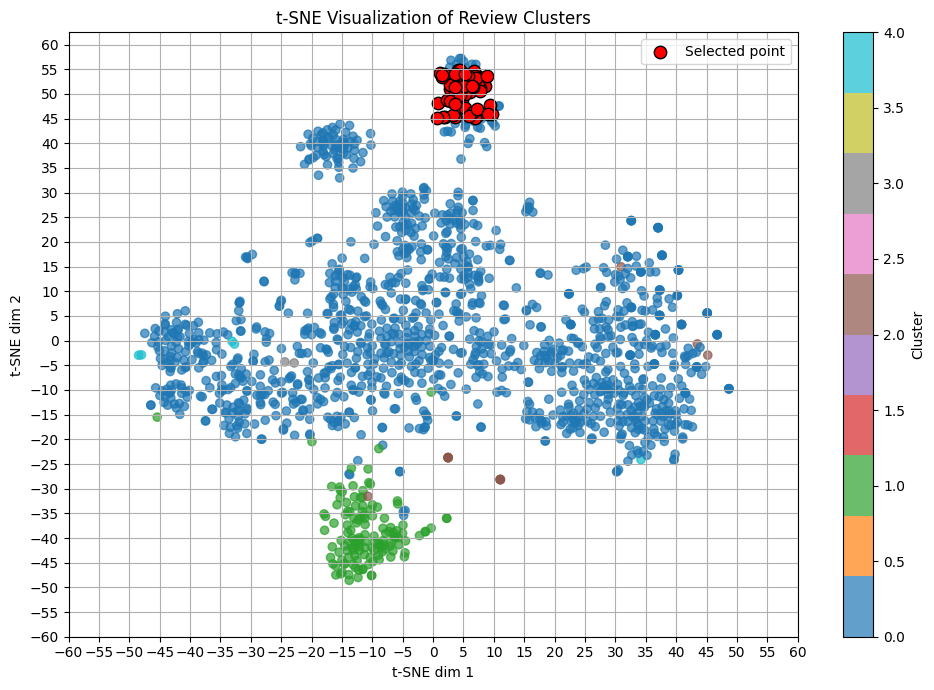

In [116]:
find_review_on_scatterplot(x_target, y_target, tolerance)